In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
from os import environ
from pathlib import Path
from einops import rearrange
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import FullCatalog, BaseTileCatalog, TileCatalog
from bliss.surveys.dc2 import DC2DataModule
from case_studies.redshift.evaluation.utils.load_lsst import get_lsst_full_cat
from case_studies.redshift.evaluation.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.redshift.redshift_from_img.encoder.metrics import RedshiftMeanSquaredErrorBin

environ["BLISS_HOME"] = str(Path().resolve().parents[2])

output_dir = Path("./DC2output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "/home/qiaozhih/bliss/case_studies/redshift/redshift_from_img/DC2_redshift_training/DC2_redshift_only_bin_allmetrics/checkpoints/encoder_0.162013.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_plot")

In [4]:
# set up testing dataset
dataset = instantiate(notebook_cfg.train.data_source)
dataset.setup("test")


In [5]:
dataset.test_dataset

In [6]:
import os
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

In [7]:
len(dataset.test_dataset)

25000

In [8]:
notebook_cfg.encoder.var_dist.factors

[{'_target_': 'bliss.encoder.variational_dist.NormalFactor', 'name': 'redshifts', 'sample_rearrange': 'b ht wt -> b ht wt 1 1', 'nll_rearrange': 'b ht wt 1 1 -> b ht wt', 'nll_gating': 'is_galaxy'}]

# blendedness for bliss

In [71]:
# Loop through the test set and update the metric
# load bliss trained model
bliss_encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

In [13]:
bliss_output_path = output_dir / "bliss_output_large_split_blend.pkl"

if not bliss_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_out_dict = bliss_encoder.mode_metrics.compute()

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

In [83]:
bliss_out_dict

{'redshifts/mse': 0.1655571311712265,
 'redshifts/mse_blend_0': 0.14102621376514435,
 'redshifts/mse_blend_1': 0.11978103965520859,
 'redshifts/mse_blend_2': 0.18335068225860596,
 'redshifts/mse_blend_3': 0.1890207827091217,
 'redshifts/mse_blend_4': 0.17960305511951447,
 'redshifts/mse_blend_5': 0.35343727469444275,
 'redshifts/mse_bin_0': 0.03979261964559555,
 'redshifts/mse_bin_1': 0.05944311246275902,
 'redshifts/mse_bin_2': 0.06494078040122986,
 'redshifts/mse_bin_3': 0.08477448672056198,
 'redshifts/mse_bin_4': 0.128226175904274,
 'redshifts/mse_bin_5': 0.2462797313928604}

# blendedness for lsst

In [9]:
import GCRCatalogs
import pandas as pd
import torch
from case_studies.redshift.network_rs import PhotoZFromMag
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from bliss.catalog import FullCatalog, SourceType

num_bins = 1
group_size = 128
batch_size = 1
in_dim = 6
device = "cuda"
path = "/data/scratch/qiaozhih/training_runs/00120-run/tensorboard_logs/version_0/checkpoints/reg_val_loss=0.000367_epoch=29.ckpt"
network_options = {
    "hidden_dim": 256,
    "out_dim": num_bins,
    "n_epochs": 50001,
    "outdir": "/home/qiaozhih/bliss/case_studies/redshift/training_runs/",
    "snap": 1,  # how many epoches to save one model once
    "loss_fcn": torch.nn.MSELoss(),  # loss func
    # 'loss_fcn': torch.nn.CrossEntropyLoss(),                     # loss func
    "dropout_rate": 0.5,
    "learning_rate": 1e-3,
    "group_size": group_size,
    "num_gpu": 1,
    "gpu_device": [0],
}

reg = PhotoZFromMag.load_from_checkpoint(
    path,
    in_dim=in_dim,
    hidden_dim=network_options["hidden_dim"],
    out_dim=network_options["out_dim"],
    dropout_rate=network_options["dropout_rate"],
    learning_rate=network_options["learning_rate"],
    loss_fcn=network_options["loss_fcn"],
)
reg.to(device)
reg.eval()

def est_redshifts_with_reg_change_to_cat(cat: TileCatalog, reg: PhotoZFromMag, tile_slen: int, min_flux_for_loss: int=50, reference_band: int=2) -> BaseTileCatalog | FullCatalog:
    """estimate redshift by inputting true mag using regressor, then convert them to Basetilecatalog

    Args:
        cat: catalog
        reg: regressor that accept ugrizy mag

    Returns:
        Catalog that containing pred redshifts
    """
    cat = cat.filter_by_flux(
        min_flux=min_flux_for_loss,
        band=reference_band,
    )
    mag = cat.on_njymag

    new_order = [3, 0, 2, 1, 5, 4] # change giruyz to ugrizy
    mag = mag[..., new_order]
    is_galaxy = cat.galaxy_bools.to(device)
    N, H, W, M, _ = mag.shape
    mag = mag.reshape(-1, 6)
    is_galaxy = is_galaxy.reshape(-1, 1)
    pred_rs = torch.zeros_like(mag[..., 0])
    for i in range(len(mag)):
        if is_galaxy[i][0]: 
            x = mag[i].unsqueeze(0).to(device) # 1, 6
            pred_rs[i] = reg.net(x).squeeze(0)
    pred_rs = pred_rs.to('cpu')
    pred_rs = {"redshifts": pred_rs.reshape((N, H, W, M, 1))}

    cat["redshifts"] = pred_rs["redshifts"]
    return cat

# load lsst data
def get_lsst_catalog_tensors_dict(lsst_root_dir: str):
    GCRCatalogs.set_root_dir(lsst_root_dir)
    lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
        [
            "id_truth",
            "objectId",
            "ra",
            "dec",
            "truth_type",
            "cModelFlux_u",
            "cModelFluxErr_u",
            "cModelFlux_g",
            "cModelFluxErr_g",
            "cModelFlux_r",
            "cModelFluxErr_r",
            "cModelFlux_i",
            "cModelFluxErr_i",
            "cModelFlux_z",
            "cModelFluxErr_z",
            "cModelFlux_y",
            "cModelFluxErr_y",
        ]
    )
    lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
    lsst_flux_lst = [
        lsst_catalog_df["cModelFlux_g"],
        lsst_catalog_df["cModelFlux_i"],
        lsst_catalog_df["cModelFlux_r"],
        lsst_catalog_df["cModelFlux_u"],
        lsst_catalog_df["cModelFlux_y"],
        lsst_catalog_df["cModelFlux_z"],
    ]
    lsst_flux_tensors_lst = [torch.tensor(flux.values).view(-1, 1) for flux in lsst_flux_lst]
    return {
        "truth_type": torch.tensor(lsst_catalog_df["truth_type"].values).view(-1, 1),
        "flux": torch.cat(lsst_flux_tensors_lst, dim=1),
        "ra": torch.tensor(lsst_catalog_df["ra"].values),
        "dec": torch.tensor(lsst_catalog_df["dec"].values),
    }
    
def get_lsst_catalog_tensors_dict(lsst_root_dir: str):
    GCRCatalogs.set_root_dir(lsst_root_dir)
    lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
        [
            "id_truth",
            "objectId",
            "ra",
            "dec",
            "truth_type",
            "cModelFlux_u",
            "cModelFluxErr_u",
            "cModelFlux_g",
            "cModelFluxErr_g",
            "cModelFlux_r",
            "cModelFluxErr_r",
            "cModelFlux_i",
            "cModelFluxErr_i",
            "cModelFlux_z",
            "cModelFluxErr_z",
            "cModelFlux_y",
            "cModelFluxErr_y",
        ]
    )
    lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
    lsst_flux_lst = [
        lsst_catalog_df["cModelFlux_g"],
        lsst_catalog_df["cModelFlux_i"],
        lsst_catalog_df["cModelFlux_r"],
        lsst_catalog_df["cModelFlux_u"],
        lsst_catalog_df["cModelFlux_y"],
        lsst_catalog_df["cModelFlux_z"],
    ]
    lsst_flux_tensors_lst = [torch.tensor(flux.values).view(-1, 1) for flux in lsst_flux_lst]
    return {
        "truth_type": torch.tensor(lsst_catalog_df["truth_type"].values).view(-1, 1),
        "flux": torch.cat(lsst_flux_tensors_lst, dim=1),
        "ra": torch.tensor(lsst_catalog_df["ra"].values),
        "dec": torch.tensor(lsst_catalog_df["dec"].values),
    }

import torch

from bliss.catalog import FullCatalog, SourceType, TileCatalog
from bliss.surveys.dc2 import wcs_from_wcs_header_str

def concatenate_tile_dicts(tile_dict_list):
    output_tile_cat_dict = {}
    for k in tile_dict_list[0].keys():
        if k not in output_tile_cat_dict:
            output_tile_cat_dict[k] = []
        for tile_dict in tile_dict_list:
            output_tile_cat_dict[k].append(tile_dict[k])

    for k, v in output_tile_cat_dict.items():
        output_tile_cat_dict[k] = torch.cat(v, dim=0)

    return output_tile_cat_dict


class LSSTPredictor:
    def __init__(
        self, lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile,
    ) -> None:
        self.lsst_data = get_lsst_catalog_tensors_dict(lsst_root_dir)
        self.r_band_min_flux = r_band_min_flux
        self.tile_slen = tile_slen
        self.max_sources_per_tile = max_sources_per_tile

        self.buffered_wcs_header_str = None
        self.buffered_lsst_plocs = None

    def _predict_one_image(self, wcs_header_str, image_lim, height_index, width_index):
        if wcs_header_str != self.buffered_wcs_header_str:
            lsst_ra = self.lsst_data["ra"]
            lsst_dec = self.lsst_data["dec"]
            cur_image_wcs = wcs_from_wcs_header_str(wcs_header_str)
            lsst_plocs = FullCatalog.plocs_from_ra_dec(lsst_ra, lsst_dec, cur_image_wcs)
            self.buffered_wcs_header_str = wcs_header_str
            self.buffered_lsst_plocs = lsst_plocs
        else:
            lsst_plocs = self.buffered_lsst_plocs
    
        lsst_source_type = self.lsst_data["truth_type"]
        lsst_flux = self.lsst_data["flux"]

        x0_mask = (lsst_plocs[:, 0] > height_index * image_lim) & (
            lsst_plocs[:, 0] < (height_index + 1) * image_lim
        )
        x1_mask = (lsst_plocs[:, 1] > width_index * image_lim) & (
            lsst_plocs[:, 1] < (width_index + 1) * image_lim
        )
        lsst_x_mask = x0_mask * x1_mask
        # filter r band
        filter_band = ["g", "i", "r", "u", "y", "z"]
        for i in range(len(filter_band)):
            lsst_flux_mask = (lsst_flux[:, i] > self.r_band_min_flux) & (lsst_flux[:, i] < torch.inf)
            lsst_x_mask = lsst_x_mask * lsst_flux_mask

        lsst_mask = lsst_x_mask
        lsst_plocs = lsst_plocs[lsst_mask, :] % image_lim
        lsst_source_type = torch.where(
            lsst_source_type[lsst_mask] == SourceType.STAR, SourceType.STAR, SourceType.GALAXY
        )
        lsst_flux = lsst_flux[lsst_mask, :]
        lsst_n_sources = torch.tensor([lsst_plocs.shape[0]])

        return FullCatalog(
            height=image_lim,
            width=image_lim,
            d={
                "plocs": lsst_plocs.unsqueeze(0),
                "n_sources": lsst_n_sources,
                "source_type": lsst_source_type.unsqueeze(0),
                "galaxy_fluxes": lsst_flux.unsqueeze(0),
                "star_fluxes": lsst_flux.unsqueeze(0).clone(),
            },
        ).to_tile_catalog(self.tile_slen, self.max_sources_per_tile, ignore_extra_sources=True)

    def predict(self, wcs_header_str_list, image_lim, height_index_list, width_index_list):
        assert len(wcs_header_str_list) == len(height_index_list), "unequal input list size"
        assert len(wcs_header_str_list) == len(width_index_list), "unequal input list size"
        tile_dict_list = []
        predict_input_data = zip(wcs_header_str_list, height_index_list, width_index_list)
        for wcs_header_str, height_index, width_index in predict_input_data:
            tile_dict_list.append(
                self._predict_one_image(wcs_header_str, image_lim, height_index, width_index).data
            )

        merged_tile_dict = concatenate_tile_dicts(tile_dict_list)
        return TileCatalog(merged_tile_dict)


In [10]:
lsst_output_path = output_dir / "lsst_output_large_split_blend.pkl"
if not lsst_output_path.exists():
    metrics = instantiate(notebook_cfg.encoder.mode_metrics)
    matcher = instantiate(notebook_cfg.encoder.matcher)
    metrics.reset()
    # args
    lsst_root_dir = "/data/scratch/dc2_nfs/"
    image_lim = 80
    r_band_min_flux = 50
    tile_slen = 4
    max_sources_per_tile = 1
    max_batch = 300

    lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile)
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        true_cat = TileCatalog(d=batch["tile_catalog"]).get_brightest_sources_per_tile()
        lsst_cat = lsst_predictor.predict(batch["wcs_header_str"], image_lim, batch["image_height_index"], batch["image_width_index"])
        est_cat = est_redshifts_with_reg_change_to_cat(lsst_cat, reg, tile_slen=4)
        est_cat = est_cat.to_full_catalog(tile_slen=4)
        true_cat = true_cat.to_full_catalog(tile_slen=4)
        matching = matcher.match_catalogs(true_cat, est_cat)
        metrics.update(true_cat, est_cat, matching)
        if not (batch_idx < max_batch or max_batch < 0):
            break

    lsst_out_dict = metrics.compute()

    with open(lsst_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(lsst_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(lsst_output_path, "rb") as inputp:
        lsst_out_dict = pickle.load(inputp)

  5%|▍         | 300/6250 [03:23<1:07:13,  1.47it/s]

total num of pts: tensor([4692.])
total num of pts: tensor([1692., 1897.,  662.,  229.,  169.,   43.])
total num of pts: tensor([1026.,  137.,  359.,  490., 1210., 1470.])


# plot

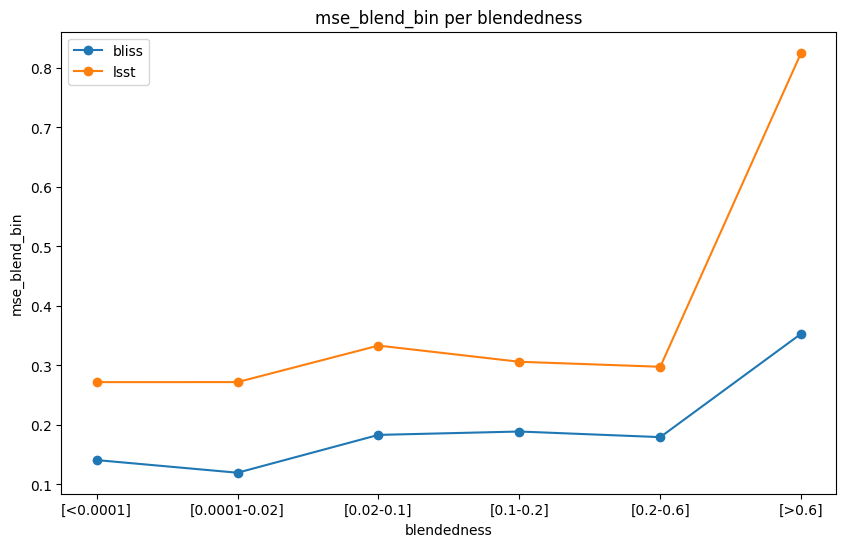

In [33]:
metrics = ['mse_blend_bin']
fig, ax = plt.subplots(len(metrics), figsize=(10, 6))
for i, metric in enumerate(metrics):
    blendedness_ranges = ['[<0.0001]', '[0.0001-0.02]', '[0.02-0.1]', '[0.1-0.2]', '[0.2-0.6]', '[>0.6]']
    bliss_values = [bliss_out_dict[f'redshifts/{metric}_{i}'] for i in range(len(blendedness_ranges))]
    lsst_values = [lsst_out_dict[f'redshifts/{metric}_{i}'] for i in range(len(blendedness_ranges))]
    if len(metrics) == 1:
        ax.plot(blendedness_ranges, bliss_values, label="bliss", marker='o')
        ax.plot(blendedness_ranges, lsst_values, label="lsst", marker='o')
        ax.set_xlabel('blendedness')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} per blendedness')
        ax.legend(loc='upper left')
    else:
        ax[i].plot(blendedness_ranges, bliss_values, label="bliss", marker='o')
        ax[i].plot(blendedness_ranges, lsst_values, label="lsst", marker='o')
        ax[i].set_xlabel('blendedness')
        ax[i].set_ylabel(metric)
        ax[i].set_title(f'{metric} per blendedness')
        ax[i].legend(loc='upper left')
plt.show()